<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

Author: [Yury Kashnitskiy](https://yorko.github.io). Translated by Anna Larionova. This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center> Topic 6. Regression</center>
## <center>Lasso and Ridge Regressions</center>

*Lecture syllabus differs this week from the article outline, because topic 4 (linear models) is too huge and important, so we cover regression this week.*

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'
import seaborn as sns

sns.set()  # just to use the seaborn theme


from sklearn.datasets import load_boston
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold, cross_val_score

**We will work with Boston house prices data (UCI repository).**
**Download the data.**

In [2]:
boston = load_boston()
X, y = boston["data"], boston["target"]

**Let's read description of data:**

In [3]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

**Let's look at the first two records.**

In [5]:
X[:2]

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01,
        6.5750e+00, 6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02,
        1.5300e+01, 3.9690e+02, 4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9690e+02, 9.1400e+00]])

## Lasso Regression

Lasso regression minimizes mean squared error with L1 regularization:
$$\Large error(X, y, w) = \frac{1}{2} \sum_{i=1}^\ell {(y_i - w^Tx_i)}^2 + \alpha \sum_{i=1}^d |w_i|$$

where $y = w^Tx$ hyperplane equation depending on model parameters $w$, $\ell$ is number of observations in data $X$, $d$ is number of features, $y$ target values, $\alpha$ regularization coefficient.

**Let's fit Lasso Regression with the small $\alpha$ coefficient (weak regularization). Coefficient related to NOX feature (nitric oxides concentration) will be zero. It means that this feature is the least important for median house prices prediction in this region.**

In [6]:
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
lasso.coef_

array([-0.09789363,  0.04921111, -0.03661906,  0.95519003, -0.        ,
        3.70320175, -0.01003698, -1.16053834,  0.27470721, -0.01457017,
       -0.77065434,  0.01024917, -0.56876914])

**Let's train Lasso Regression with $\alpha=10$. All of the coefficients are equal to zero except features ZN (proportion of residential land zoned for lots over 25,000 sq.ft.), TAX (full-value property-tax rate), B (proportion of blacks by town) and LSTAT (% of lower status of the population).**

In [7]:
lasso = Lasso(alpha=10)
lasso.fit(X, y)
lasso.coef_

array([-0.        ,  0.02614602, -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.00928242,
       -0.        ,  0.00749584, -0.56403807])

**It means that Lasso Regression may serve as a feature selection method.**

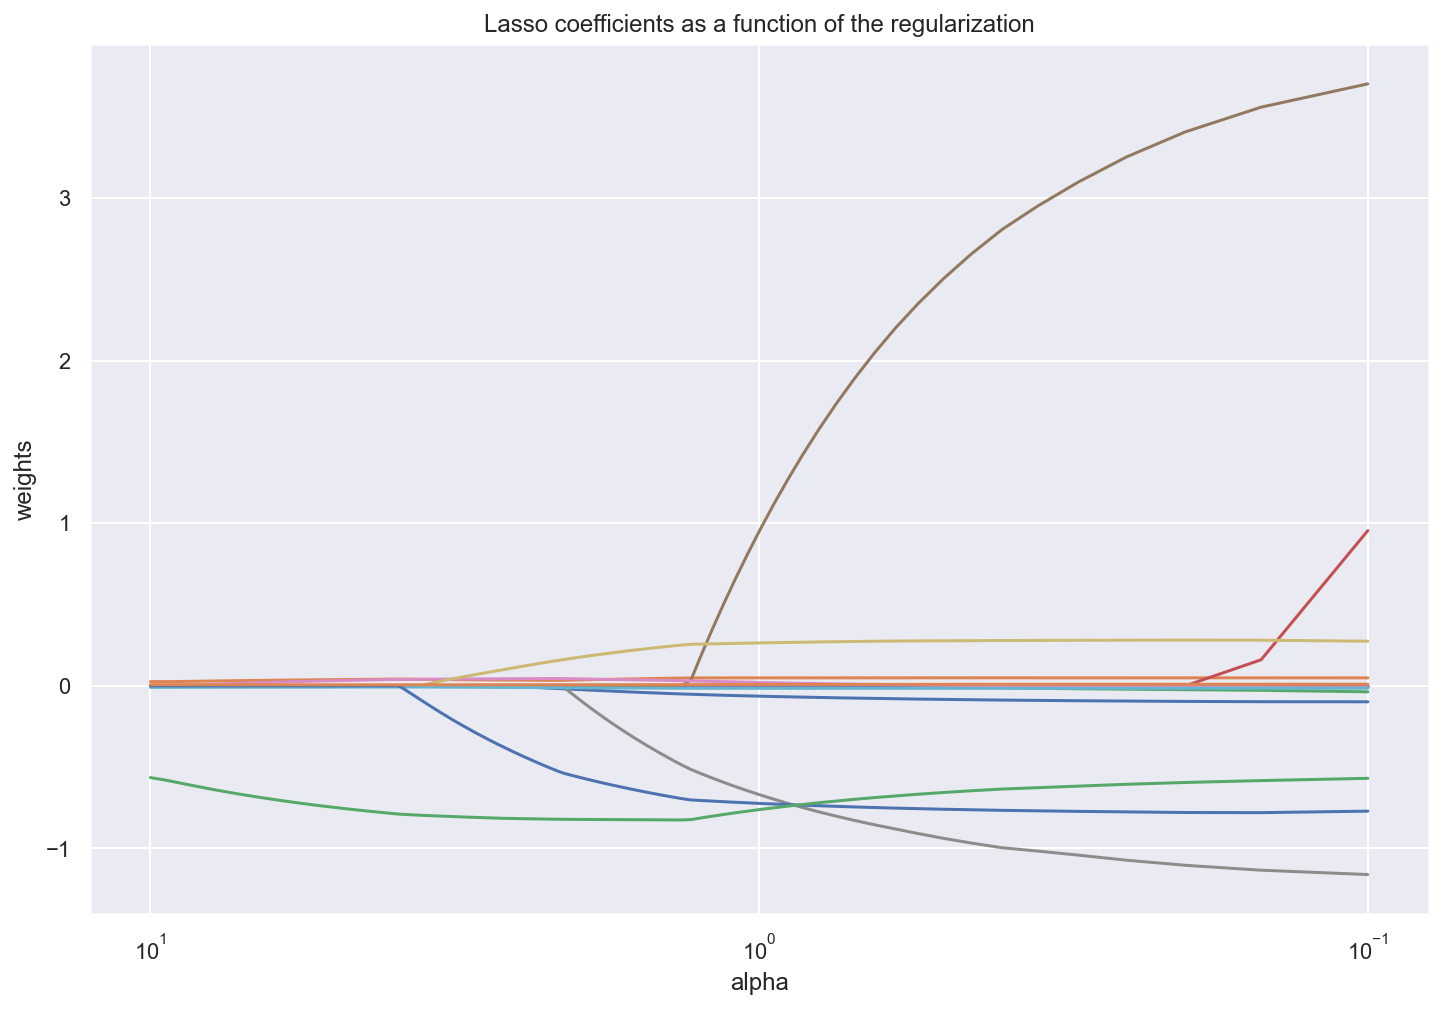

In [8]:
n_alphas = 200
alphas = np.linspace(0.1, 10, n_alphas)
model = Lasso()

coefs = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(X, y)
    coefs.append(model.coef_)

plt.rcParams["figure.figsize"] = (12, 8)

ax = plt.gca()
# ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization")
plt.axis("tight")
plt.show();

**Now let's find the best value of $\alpha$ during cross-validation.**

In [9]:
lasso_cv = LassoCV(alphas=alphas, cv=3, random_state=17)
lasso_cv.fit(X, y)

LassoCV(alphas=array([ 0.1       ,  0.14974874,  0.19949749,  0.24924623,  0.29899497,
        0.34874372,  0.39849246,  0.44824121,  0.49798995,  0.54773869,
        0.59748744,  0.64723618,  0.69698492,  0.74673367,  0.79648241,
        0.84623116,  0.8959799 ,  0.94572864,  0.99547739,  1.04522613,
        1.09497487,  1.14472362,  1.19447236,  1.24422111,  1.29396985,
        1.34371859,  1.39346734,  1.44321608,  1.49296482,  1.54271357,
        1.5924...
        8.30854271,  8.35829146,  8.4080402 ,  8.45778894,  8.50753769,
        8.55728643,  8.60703518,  8.65678392,  8.70653266,  8.75628141,
        8.80603015,  8.85577889,  8.90552764,  8.95527638,  9.00502513,
        9.05477387,  9.10452261,  9.15427136,  9.2040201 ,  9.25376884,
        9.30351759,  9.35326633,  9.40301508,  9.45276382,  9.50251256,
        9.55226131,  9.60201005,  9.65175879,  9.70150754,  9.75125628,
        9.80100503,  9.85075377,  9.90050251,  9.95025126, 10.        ]),
        cv=3, random_state=17

In [10]:
lasso_cv.coef_

array([-0.09739888,  0.04946381, -0.02749478,  0.16060406, -0.        ,
        3.55971374, -0.00726968, -1.13393157,  0.28096773, -0.01503453,
       -0.77985441,  0.01025033, -0.58259584])

In [11]:
lasso_cv.alpha_

0.14974874371859298

**In Scikit-learn, metrics are typically *maximized*, so for MSE there's a workaround: `neg_mean_squared_error` is minimized instead. Not really convenient.**

In [12]:
cross_val_score(Lasso(lasso_cv.alpha_), X, y, cv=3, scoring="neg_mean_squared_error")

array([-16.89312641, -37.56646167, -72.42092752])

In [13]:
abs(
    cross_val_score(
        Lasso(lasso_cv.alpha_), X, y, cv=3, scoring="neg_mean_squared_error"
    ).mean()
)

42.29350519915075

In [14]:
abs(np.mean(cross_val_score(Lasso(9.95), X, y, cv=3, scoring="neg_mean_squared_error")))

53.72266087715847

**One more ambiguous point: LassoCV sorts values of the parameters in decreasing order to ease optimization. It may seem that $\alpha$ optimization works incorrectly.**

In [15]:
lasso_cv.alphas[:10]

array([0.1       , 0.14974874, 0.19949749, 0.24924623, 0.29899497,
       0.34874372, 0.39849246, 0.44824121, 0.49798995, 0.54773869])

In [16]:
lasso_cv.alphas_[:10]

array([10.        ,  9.95025126,  9.90050251,  9.85075377,  9.80100503,
        9.75125628,  9.70150754,  9.65175879,  9.60201005,  9.55226131])

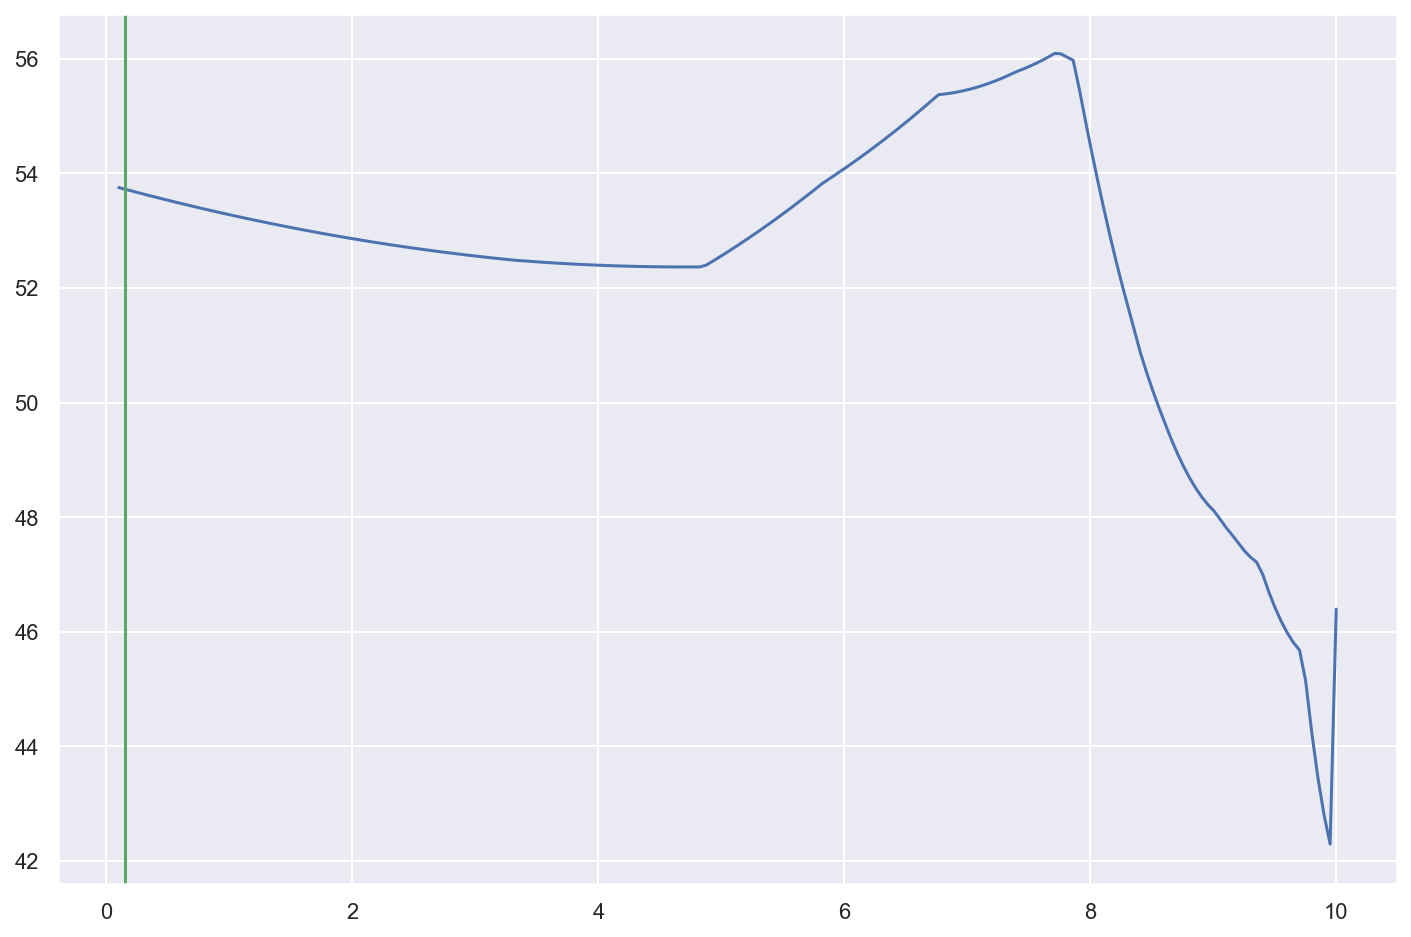

In [17]:
plt.plot(lasso_cv.alphas, lasso_cv.mse_path_.mean(1))  # incorrect
plt.axvline(lasso_cv.alpha_, c="g");

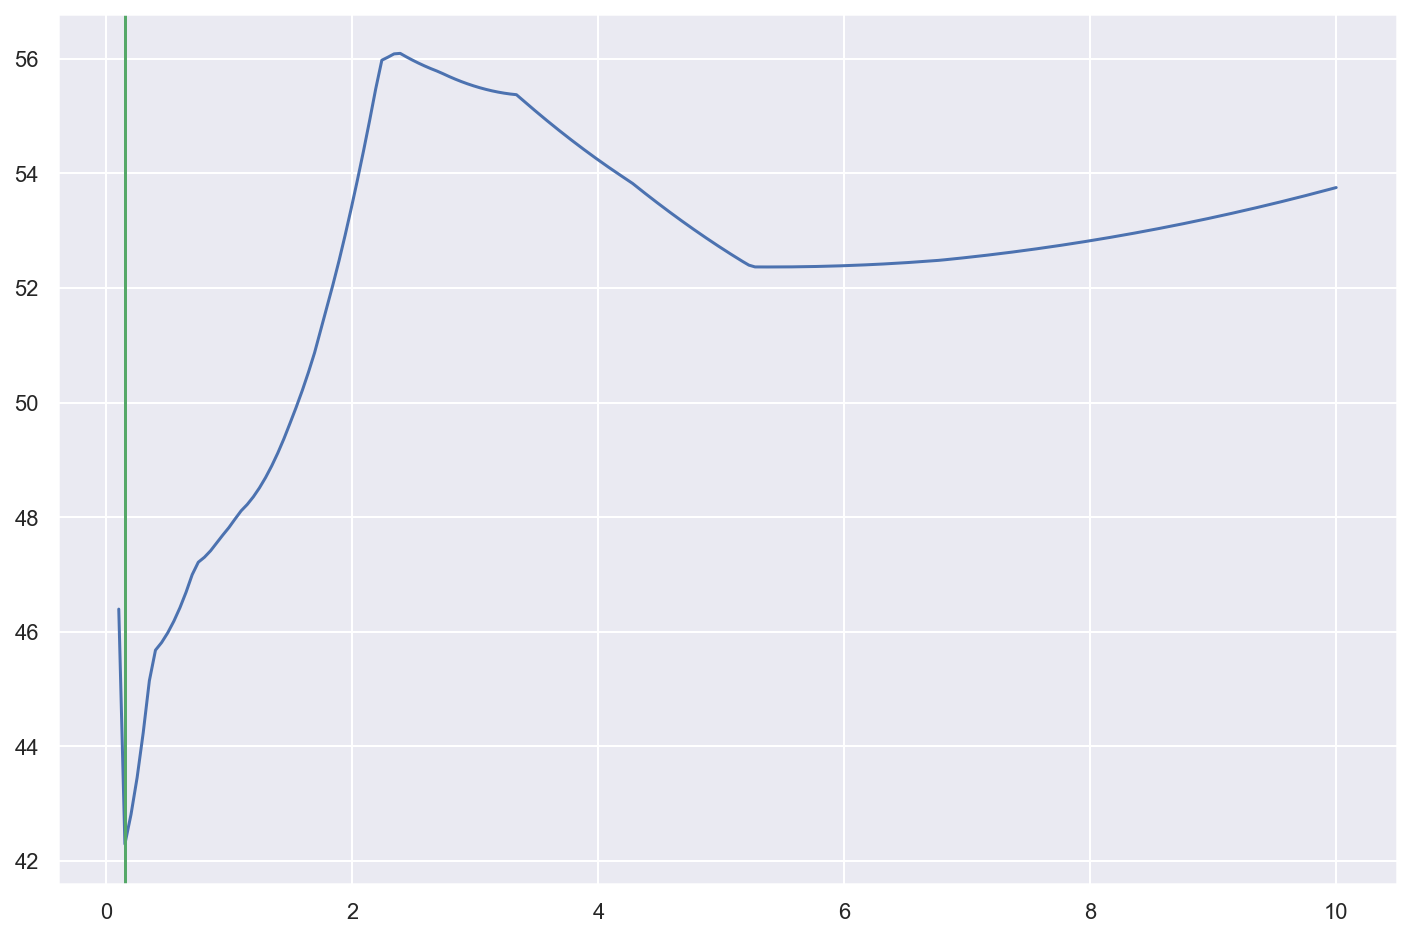

In [18]:
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(1))  # correct
plt.axvline(lasso_cv.alpha_, c="g");

## Ridge Regression

Ridge regression minimizes mean squared error with L2 regularization:
$$\Large error(X, y, w) = \frac{1}{2} \sum_{i=1}^\ell {(y_i - w^Tx_i)}^2 + \alpha \sum_{i=1}^d w_i^2$$

where $y = w^Tx$ hyperplane equation depending on model parameters $w$, $\ell$ is number of observations in data $X$, $d$ is number of features, $y$ target values, $\alpha$ regularization coefficient.

There is a special class [RidgeCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) for Ridge regression cross-validation.

In [19]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)

In [20]:
ridge_cv = RidgeCV(alphas=ridge_alphas, scoring="neg_mean_squared_error", cv=3)
ridge_cv.fit(X, y)

RidgeCV(alphas=array([1.00000000e-02, 1.09698580e-02, 1.20337784e-02, 1.32008840e-02,
       1.44811823e-02, 1.58856513e-02, 1.74263339e-02, 1.91164408e-02,
       2.09704640e-02, 2.30043012e-02, 2.52353917e-02, 2.76828663e-02,
       3.03677112e-02, 3.33129479e-02, 3.65438307e-02, 4.00880633e-02,
       4.39760361e-02, 4.82410870e-02, 5.29197874e-02, 5.80522552e-02,
       6.36824994e-02, 6.98587975e-0...
       1.18953407e+05, 1.30490198e+05, 1.43145894e+05, 1.57029012e+05,
       1.72258597e+05, 1.88965234e+05, 2.07292178e+05, 2.27396575e+05,
       2.49450814e+05, 2.73644000e+05, 3.00183581e+05, 3.29297126e+05,
       3.61234270e+05, 3.96268864e+05, 4.34701316e+05, 4.76861170e+05,
       5.23109931e+05, 5.73844165e+05, 6.29498899e+05, 6.90551352e+05,
       7.57525026e+05, 8.30994195e+05, 9.11588830e+05, 1.00000000e+06]),
        cv=3, scoring='neg_mean_squared_error')

In [21]:
ridge_cv.alpha_

264.30814869741084

**In case of Ridge Regression neither of the parameters are reducing to zero. It can be small value but non-zero.**

In [22]:
ridge_cv.coef_

array([-0.09975818,  0.05562804, -0.05006572,  0.30202744, -0.09151777,
        1.42295311,  0.01289136, -0.99866364,  0.33080392, -0.01661515,
       -0.81984784,  0.00876309, -0.72318342])

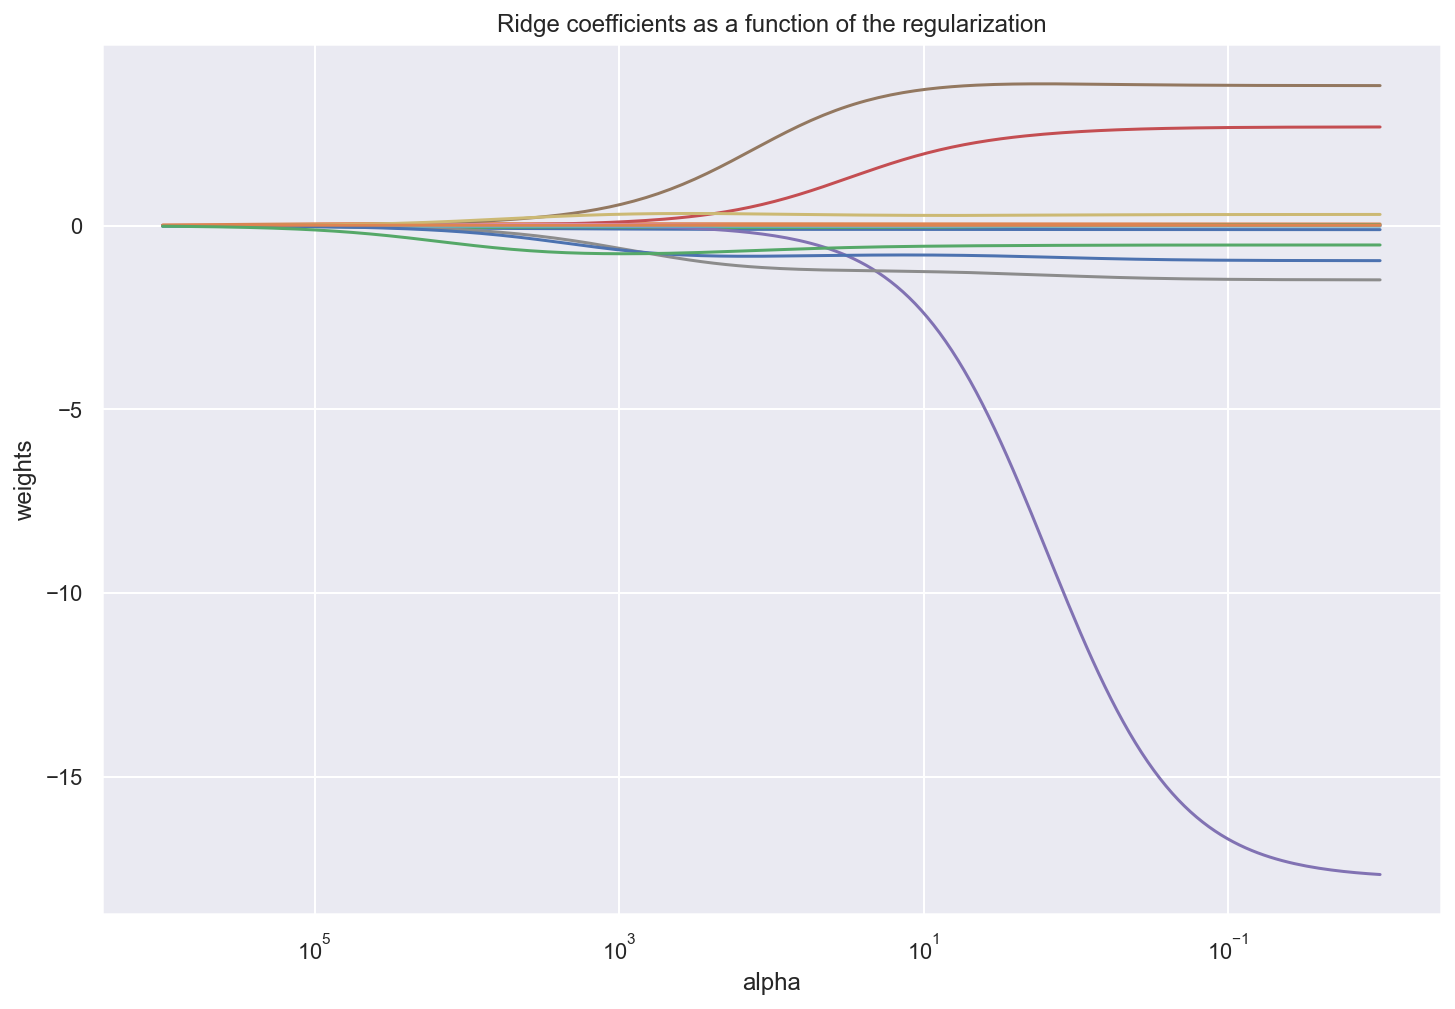

In [23]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)
model = Ridge()

coefs = []
for a in ridge_alphas:
    model.set_params(alpha=a)
    model.fit(X, y)
    coefs.append(model.coef_)

ax = plt.gca()
# ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(ridge_alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

## References
- [Generalized linear models](http://scikit-learn.org/stable/modules/linear_model.html) (Generalized Linear Models, GLM) in Scikit-learn
- [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression), [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso), [LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV), [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) and [RidgeCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) in Scikit-learn